In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy
import astropy.units as u
import astropy.constants as ac
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils
import json

import umap

from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
import open3d as o3d

import datetime
from tqdm.notebook import tqdm



2023-05-02 18:57:34.743256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
latent_size = 768
batch_size = 48
# gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)
gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=False, noise_filter=True)

25650
19012


In [3]:
all_gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0, shuffle=False, noise_filter=False)
all_gen_input.take_all = True

/home/eugeniolr/Documents/master/TFM/data_generator.py:189: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:190: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:198: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


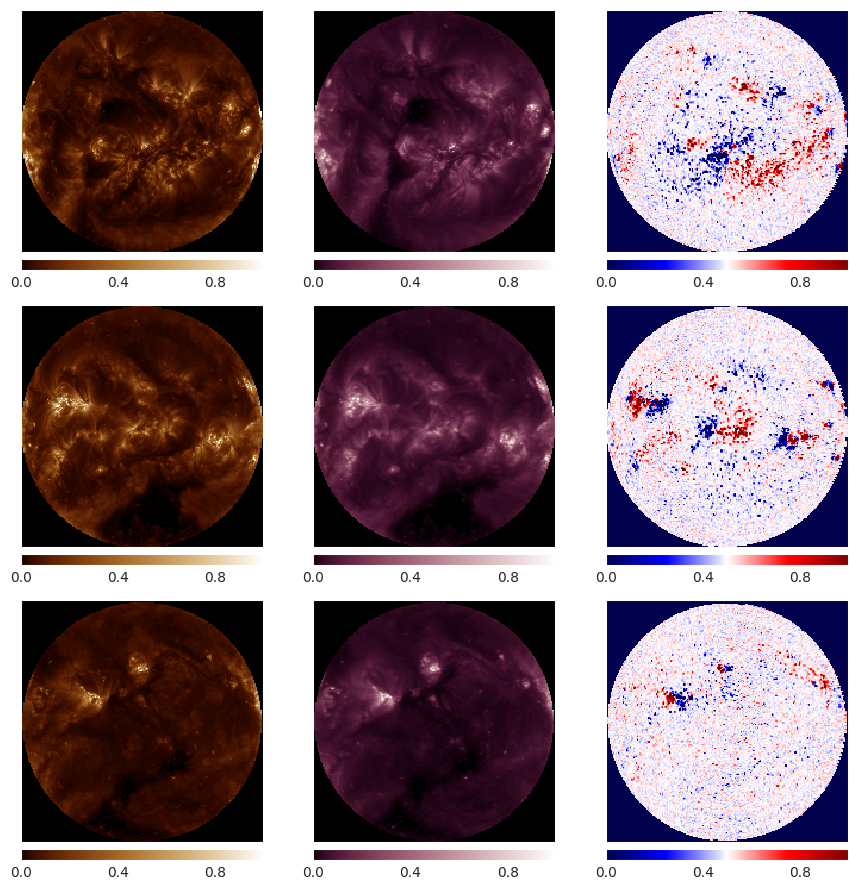

In [4]:
img_amount = 3

sample_images = gen_input.sample(img_amount)

image_list = []
for data_image in sample_images:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)


In [5]:
print("train using the script")
# latent_size = 1024
# # optimizer = keras.optimizers.Adam(learning_rate=0.001)
# # optimizer = keras.optimizers.SGD(learning_rate=0.01)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

# loss_fn = "mse"

# autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

train using the script


In [6]:
print("train using the script")
# n_epochs = 1

# history = autoencoder.fit(gen_input, epochs=n_epochs)

train using the script


In [7]:
print("train using the script")
# json_history_str = json.dumps(history.history)
# with open("AE_xception_full.json", "w") as j:
#     j.write(json_history_str)

train using the script


In [8]:
print("train using the script")
# autoencoder.save("autoencoder_xception.h5")
# encoder.save("encoder_xception.h5")
# decoder.save("decoder_xception.h5")

train using the script


In [9]:
autoencoder = keras.models.load_model("autoencoder_768_xception.h5")
encoder = keras.models.load_model("encoder_768_xception.h5")
decoder = keras.models.load_model("decoder_768_xception.h5")

2023-05-02 18:57:39.314431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-02 18:57:39.323737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-02 18:57:39.323841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-05-02 18:57:41.122633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-02 18:57:42.306369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-05-02 18:57:43.751192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


316/316 [==============================] - 50s 148ms/step - loss: 0.0020 - mae: 0.0198


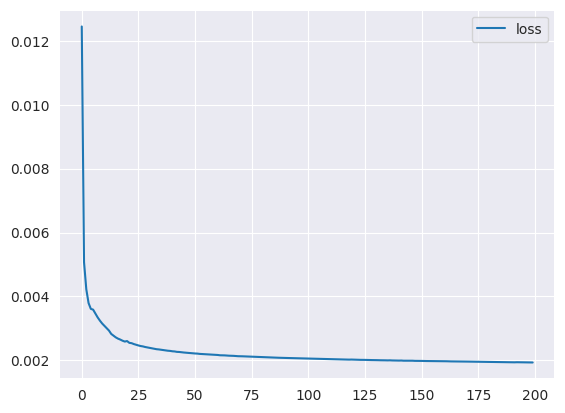

In [10]:
with open("AE_xception_full.json", "r") as j:
    history_dict = json.load(j)

gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(history_dict['loss'], label='loss')
plt.legend()
plt.show()

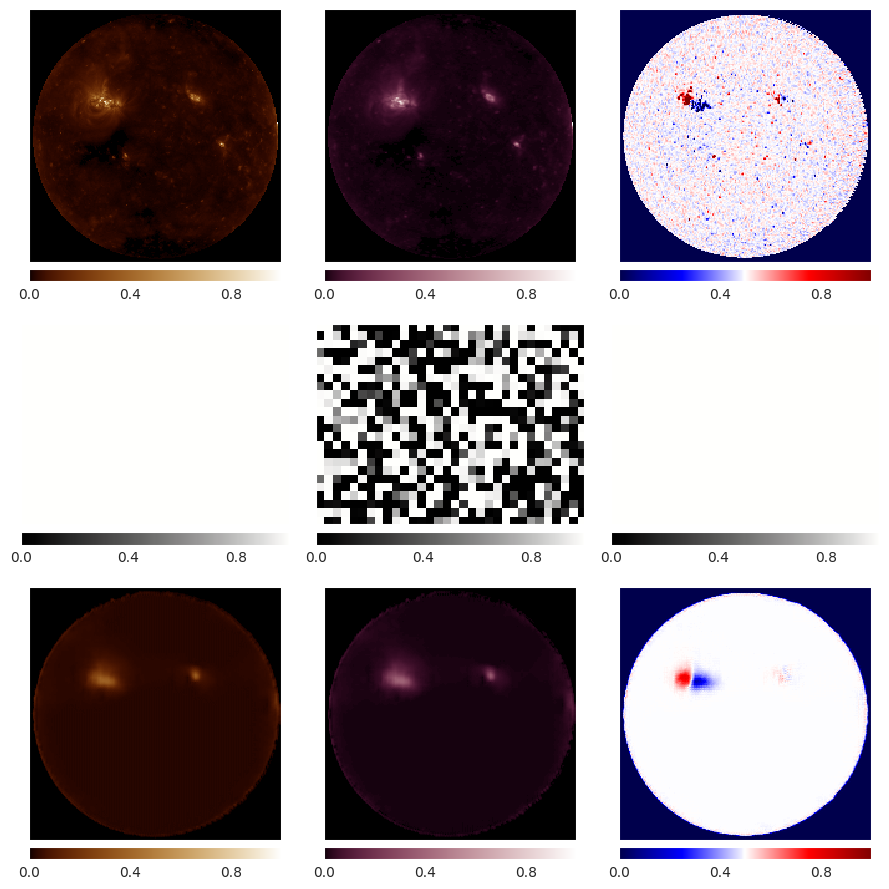

In [11]:
test_img = all_gen_input.sample(1)
code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)

In [12]:
gen_input.take_all = True
dataset_dates = [datetime.datetime.strptime(i.stem, "%Y-%m-%dT%H-%M-%S") for i in gen_input.file_list]
dataset_dates

metadata = pd.DataFrame(columns=["datetime", "is_fast_wind", "CME"])
metadata["datetime"] = dataset_dates
metadata["datetime"] = metadata["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
metadata

,datetime,is_fast_wind,CME
0,2019-02-06 03:48:48,NaN,NaN
1,2020-01-27 02:30:16,NaN,NaN
2,2016-08-27 03:44:55,NaN,NaN
3,2020-04-20 03:45:40,NaN,NaN
4,2016-07-06 01:30:06,NaN,NaN
...,...,...,...
19007,2013-10-30 06:49:23,NaN,NaN
19008,2017-01-22 02:30:03,NaN,NaN
19009,2014-06-13 05:45:23,NaN,NaN
19010,2013-10-18 04:04:50,NaN,NaN


In [13]:
solar_wind_db = pd.read_csv("./omni_1hr_clean.csv")

solar_wind_db["is_fast_wind"] = (solar_wind_db["V"] > 550).astype(int)
solar_wind_db["datetime"] = pd.to_datetime(solar_wind_db["datetime"], format="%Y-%m-%d %H:%M:%S")
solar_wind_db = solar_wind_db[solar_wind_db["datetime"] >= min(dataset_dates)]
solar_wind_db["datetime"] = solar_wind_db["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

solar_wind_db[solar_wind_db["is_fast_wind"] == 1].count()
solar_wind_db = solar_wind_db.dropna()
solar_wind_db

,datetime,BR,BT,BN,V,N,T,is_fast_wind
141772,2012-10-03 04:00:00,-3.3,-0.8,4.6,327.0,8.2,8305.0,0
141773,2012-10-03 05:00:00,-2.5,-0.1,4.5,325.0,10.4,11632.0,0
141774,2012-10-03 06:00:00,-2.4,0.2,3.0,327.0,7.8,16789.0,0
141775,2012-10-03 07:00:00,-0.3,-2.5,-0.4,327.0,8.0,19029.0,0
141776,2012-10-03 08:00:00,1.1,-1.8,-2.3,332.0,6.9,23107.0,0
...,...,...,...,...,...,...,...,...
222812,2021-12-31 20:00:00,-0.6,-2.0,4.2,418.0,7.8,78906.0,0
222813,2021-12-31 21:00:00,-1.3,-2.4,3.4,423.0,8.6,88405.0,0
222814,2021-12-31 22:00:00,1.1,-2.3,1.6,414.0,8.1,95631.0,0
222815,2021-12-31 23:00:00,4.6,-2.8,-3.8,388.0,5.0,68545.0,0


In [15]:
sw_dates = []
for index, row in solar_wind_db.iterrows():
    measurement_date = datetime.datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")

    wind_delay = (ac.au / (row["V"] * (u.km/u.s))).decompose()
    wind_delay = datetime.timedelta(seconds=wind_delay.value)

    photo_delay = (ac.au / ac.c).decompose()
    photo_delay = datetime.timedelta(seconds=photo_delay.value)

    origin_date = measurement_date - wind_delay + photo_delay
    sw_dates.append(origin_date)

    # measurement_date = datetime.datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
    # origin_date = measurement_date
    # sw_dates.append(origin_date)

for idx, date_sw_str in tqdm(enumerate(metadata["datetime"]), total=len(metadata), desc="Creating fast solar wind dataframe"):
    date_sw = datetime.datetime.strptime(date_sw_str, "%Y-%m-%d %H:%M:%S")
    date_dist = [abs(date_sw - i) for i in sw_dates]
    if min(date_dist) < datetime.timedelta(hours=4):
        date_idx = date_dist.index(min(date_dist))
        metadata.at[idx, "is_fast_wind"] = solar_wind_db.iloc[date_idx]["is_fast_wind"]

    
metadata[metadata["is_fast_wind"] == 1]

# min([datetime.datetime.strptime(i.stem, "%Y-%m-%dT%H-%M-%S") for i in gen_input.file_list]), min([datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in metadata["datetime"]])
# min([i for i in gen_input.file_list]), min(metadata["datetime"])

Creating fast solar wind dataframe:   0%|          | 0/19012 [00:00<?, ?it/s]

,datetime,is_fast_wind,CME
4,2016-07-06 01:30:06,1,NaN
30,2018-10-11 18:03:46,1,NaN
37,2017-11-18 06:55:21,1,NaN
42,2016-10-24 05:09:34,1,NaN
48,2017-08-18 02:32:55,1,NaN
...,...,...,...
18991,2015-03-31 04:57:17,1,NaN
18993,2017-05-13 06:13:19,1,NaN
18998,2016-12-24 07:55:46,1,NaN
19000,2019-09-01 06:09:30,1,NaN


In [16]:
cme_db = pd.read_csv("./CME_database.csv")

cme_db["CME Start"] = pd.to_datetime(cme_db["CME Start"], format="%Y-%m-%d %H:%M:%S")
cme_db = cme_db[cme_db["CME Start"] >= min(dataset_dates)]
cme_db["CME Start"] = cme_db["CME Start"].dt.strftime("%Y-%m-%d %H:%M:%S")

cme_db["CME End"] = pd.to_datetime(cme_db["CME End"], format="%Y-%m-%d %H:%M:%S")
cme_db = cme_db[cme_db["CME End"] <= max(dataset_dates)]
cme_db["CME End"] = cme_db["CME End"].dt.strftime("%Y-%m-%d %H:%M:%S")

cme_db

,CME Arrival,CME Start,CME End,V_CME (km/s)
396,2012-10-08 05:16:00,2012-10-08 18:00:00,2012-10-09 12:00:00,390.0
397,2012-10-12 19:00:00,2012-10-12 22:00:00,2012-10-13 10:00:00,490.0
398,2012-10-31 15:38:00,2012-11-01 00:00:00,2012-11-02 03:00:00,340.0
399,2012-11-09 03:00:00,2012-11-09 03:00:00,2012-11-09 15:00:00,370.0
400,2012-11-12 23:11:00,2012-11-13 08:00:00,2012-11-14 03:00:00,380.0
...,...,...,...,...
514,2019-05-26 22:14:00,2019-05-27 04:00:00,2019-05-28 00:00:00,350.0
515,2019-10-29 20:00:00,2019-10-29 20:00:00,2019-10-30 21:00:00,380.0
516,2019-11-11 06:00:00,2019-11-11 10:00:00,2019-11-12 12:00:00,360.0
517,2020-01-04 10:00:00,2020-01-04 10:00:00,2020-01-05 06:00:00,370.0


In [36]:
start_dates = []
end_dates = []
for index, row in cme_db.iterrows():
    start_measurement_date = datetime.datetime.strptime(row["CME Start"], "%Y-%m-%d %H:%M:%S")
    end_measurement_date = datetime.datetime.strptime(row["CME End"], "%Y-%m-%d %H:%M:%S")

    wind_delay = (ac.au / (row["V_CME (km/s)"] * (u.km/u.s))).decompose()
    wind_delay = datetime.timedelta(seconds=wind_delay.value)

    photo_delay = (ac.au / ac.c).decompose()
    photo_delay = datetime.timedelta(seconds=photo_delay.value)

    start_date = start_measurement_date - wind_delay + photo_delay
    start_dates.append(start_date)

    end_date = end_measurement_date - wind_delay + photo_delay
    end_dates.append(end_date)

    # start_measurement_date = datetime.datetime.strptime(row["CME Start"], "%Y-%m-%d %H:%M:%S")
    # start_date = start_measurement_date - wind_delay + photo_delay
    # start_dates.append(start_date)

    # end_measurement_date = datetime.datetime.strptime(row["CME End"], "%Y-%m-%d %H:%M:%S")
    # end_date = end_measurement_date - wind_delay + photo_delay
    # end_dates.append(end_date)

for idx, date_sw_str in tqdm(enumerate(metadata["datetime"]), total=len(metadata), desc="Creating CME dataframe"):
    date_sw = datetime.datetime.strptime(date_sw_str, "%Y-%m-%d %H:%M:%S")
    in_range = np.any([(date_sw >= init_date) and (date_sw <= fin_date)  for init_date, fin_date in zip(start_dates, end_dates)])
    metadata.at[idx, "CME"] = in_range

metadata[metadata["CME"]]

Creating CME dataframe:   0%|          | 0/19012 [00:00<?, ?it/s]

,datetime,is_fast_wind,CME
10,2014-02-01 05:39:14,0,True
17,2019-05-07 05:27:37,0,True
35,2014-04-14 04:35:54,0,True
44,2019-10-25 02:45:45,0,True
48,2017-08-18 02:32:55,1,True
...,...,...,...
18965,2017-09-04 03:32:36,1,True
18971,2015-03-24 04:45:32,0,True
18976,2014-02-06 06:14:36,0,True
18982,2016-10-09 02:34:41,0,True


In [18]:
metadata.to_csv("is_fast_solar_wind.csv")
metadata

,datetime,is_fast_wind,CME
0,2019-02-06 03:48:48,0,False
1,2020-01-27 02:30:16,0,False
2,2016-08-27 03:44:55,0,False
3,2020-04-20 03:45:40,0,False
4,2016-07-06 01:30:06,1,False
...,...,...,...
19007,2013-10-30 06:49:23,0,False
19008,2017-01-22 02:30:03,0,False
19009,2014-06-13 05:45:23,0,False
19010,2013-10-18 04:04:50,0,False


In [19]:
metadata[metadata["is_fast_wind"] == 1].count()

datetime        1825
is_fast_wind    1825
CME             1825
dtype: int64

In [20]:
codes = np.empty((len(gen_input.file_list), latent_size))
for idx, val in tqdm(enumerate(gen_input), total=len(gen_input), desc="Encoding images"):
    codes[batch_size*idx:batch_size*(idx+1)] = encoder.predict(val[0], verbose=False)

Encoding images:   0%|          | 0/396 [00:00<?, ?it/s]

/home/eugeniolr/Documents/master/TFM/data_generator.py:189: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:190: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:198: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


In [29]:
dim_reducer = umap.UMAP(
    n_components=3, 
    n_neighbors=20,
    # metric='canberra', 
    metric='minkowski', 
    min_dist=0.2,
    verbose=True, 
    n_epochs=3000, 
    target_metric='euclidean',
    learning_rate=1.0,
    negative_sample_rate=30
)

In [30]:
dim_reducer.fit(codes)

UMAP(metric='minkowski', min_dist=0.2, n_components=3, n_epochs=3000, n_neighbors=20, negative_sample_rate=30, target_metric='euclidean', verbose=True)
Tue May  2 19:05:38 2023 Construct fuzzy simplicial set
Tue May  2 19:05:38 2023 Finding Nearest Neighbors
Tue May  2 19:05:38 2023 Building RP forest with 12 trees
Tue May  2 19:05:38 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue May  2 19:05:42 2023 Finished Nearest Neighbor Search
Tue May  2 19:05:42 2023 Construct embedding


Epochs completed:   0%|            0/3000 [00:00]

Tue May  2 19:07:37 2023 Finished embedding


UMAP(metric='minkowski', min_dist=0.2, n_components=3, n_epochs=3000, n_neighbors=20, negative_sample_rate=30, target_metric='euclidean', verbose=True)

In [31]:
display_all = True

if display_all:
    metadata_sample = metadata
    data_points = codes
else:
    sample_idx = random.sample(range(len(codes)), 1500)
    metadata_sample = metadata.iloc[sample_idx]
    data_points = codes[sample_idx]
    


projection = dim_reducer.transform(data_points)
projection.shape, projection.min(), projection.max()

((19012, 3), -24.007288, 34.72254)

In [32]:
point_cloud = projection

normals = (point_cloud - [np.mean(point_cloud, axis=0) for _ in point_cloud])
colors = (point_cloud + [[0.5,0.5,0.5] for _ in point_cloud])/1
print(colors)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(colors)
pcd.normals = o3d.utility.Vector3dVector(normals)

# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, .6)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd, 
    depth=8, 
    width=0, 
    scale=1.1, 
    linear_fit=False
)[0]

mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = mesh.crop(bbox)

verts = np.asarray(mesh.vertices)
tris = np.asarray(mesh.triangles)


[[-10.08167267  -6.27047253  -3.54236603]
 [ -9.59518147  -3.92945766  -5.74580956]
 [  9.42798996  16.30571747 -13.14555454]
 ...
 [ 15.22176266   2.06313825  -6.32218218]
 [ 15.22299099   2.06695414  -6.33325768]
 [ 15.22660923   2.05690968  -6.3137002 ]]


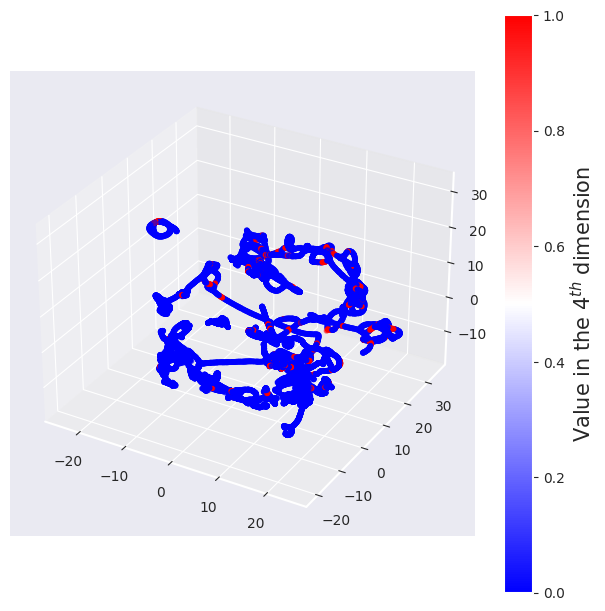

In [37]:
%matplotlib widget

display_color = "CME" # "fast_wind"

display_styles = ['Scatter', '3D model', '3D and scatter']
# display_styles = ['3D model', 'Scatter', '3D and scatter']

style_selector = widgets.Dropdown(options=display_styles, description='Select display style')
style = style_selector.value

fig = None
ax = None
cbar = None

def make_plot(style):
    global ax, fig, cbar
    created_new = False
    if not ax or not fig:
        fig = plt.figure(figsize=(7.5, 7.5))
        ax = fig.add_subplot(111, projection='3d')
        created_new = True
    else:
        ax.clear()
        if cbar:
            cbar.remove()
    
    if style == '3D model' or style == '3D and scatter':
        ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=tris,
                            shade=True, alpha=.1, antialiased=False, linewidth=0)

    if style == 'Scatter' or style == '3D and scatter':
        if display_color == "CME":
            p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=metadata_sample['CME'], 
                       s=1.0 if style == '3D and scatter' else 10.0, cmap="bwr")
        elif display_color == "fast_wind":
            p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=metadata_sample['is_fast_wind'], 
                        s=1.0 if style == '3D and scatter' else 10.0, cmap="bwr")
        

        cbar = fig.colorbar(p);
        cbar.ax.set_ylabel('Predicted speed (km/s)')
        cbar.ax.set_ylabel('Value in the 4$^{th}$ dimension')
    
    if created_new:
        plt.show()
    
def on_style_change(change):
    global style
    style = change.new
    make_plot(style)

style_selector.observe(on_style_change, names='value')
display(widgets.HBox([style_selector]))
make_plot(style)
